<div align='center'><font size=10>Implementing Twin Support Vector machine</font></div>

This notebook implemeted using original twin svm paper titled by:

Twin Support Vector Machines for Pattern Classification<br>
Jayadeva, R. Khemchandani and Suresh Chandra

IEEE TRANSACTIONS ON PATTERN ANALYSIS AND MACHINE INTELLIGENCE, VOL. 29, NO. 5, MAY 2007

Implemented by:

Abdullah Mohammadi

M.SC Student in Data Science, Ferdowsi University of mashhad(FUM),Iran

abdhmohammady@gmail.com

https://github.com/abdhmohammadi

Please to use this code star me in <a href= 'https://github.com/abdhmohammadi'>github</a>

In [1]:
import numpy
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
import os 
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import rbf_kernel , linear_kernel

from qpsolvers import solve_qp

We generate random 2-D data samples data from Normal distribution

In [2]:
n_samples = 100
negative_samples = numpy.random.multivariate_normal(mean=[0, 5], cov=[[2, 1.5],[1.5, 2]], size=n_samples)

positive_samples = numpy.random.multivariate_normal(mean=[6, 0],cov=[[2, 1.5],[1.5, 2]], size=n_samples)

samples = numpy.vstack((negative_samples,positive_samples))

neg_labels = -numpy.ones((n_samples,1))
pos_labels = numpy.ones((n_samples,1))
labels = numpy.vstack((neg_labels,pos_labels))

X = samples
y = labels

X_train,X_test,y_train, y_test = train_test_split(X,y,test_size=30)

y_train = numpy.asarray(y_train).T[0]

We assign matrix of class 1 to A and class 2 to B,<br>
and separate unique labels from train labels  

In [3]:
classes = numpy.unique(y_train)

A = numpy.asarray(X_train[y_train == classes[0]],dtype=numpy.float64) 
       
B = numpy.asarray(X_train[y_train == classes[1]],dtype=numpy.float64) 

m1 = len(A)
m2 = len(B)


From relation (25), we set e1 , e2 ,H and G 
and kernelize data using relation (34)

In [4]:
kernel_name = ''
K = None
epsilon = 0.001
e1 = numpy.ones(m1).reshape(-1,1)
e2 = numpy.ones(m2).reshape(-1,1)

In [5]:
C = numpy.vstack((A,B))

if kernel_name == 'rbf':
        K = rbf_kernel
        H = numpy.hstack((K(A,C,gamma=10),e1))
        G = numpy.hstack((K(B,C,gamma=10),e2))

elif kernel_name == 'linear':
        K = linear_kernel
        H = numpy.hstack((K(A,C),e1))
        G = numpy.hstack((K(B,C),e2))     
        
else:  # None linear 
        H = numpy.hstack((A,e1))
        G = numpy.hstack((B,e2))

coding matrix inverse for relation (26)  and (27)

$(H^TH+ \epsilon I)^{-1}$

In [6]:
H_ = numpy.linalg.inv(H.T@H + epsilon* numpy.identity(H.shape[1]))

Solving the quadratic problem relation (28),(29)<br>
to solve it we use qpsolvers package,<br>
this package solve minimization problem like below:

$minimize\ \frac{1}{2} x^T P x + q^T x$ <br>
 $subject\ to$<br>
 $G x \leq h$                
 $A x = b$                   
 $lb \leq x \leq ub$



First Hyper plane

In [7]:
c1 = 10  # hyper-parameter 

P = G @ H_ @ G.T
alpha = solve_qp(P = P ,q = -e2.T, lb = numpy.zeros(m2), ub = c1 * numpy.ones(m2),solver='cvxopt')

alpha = alpha.reshape(m2,1)

u = -H_ @ G.T @ alpha

b1 = numpy.float64(u[len(u)-1])

w1 =u[:len(u)-1].T[0]


Second Heper plan

In [8]:
c2 = 0.5
# Secund hyperplane
G_ = numpy.linalg.inv(G.T @ G + epsilon * numpy.eye(G.shape[1]))

P = H @ G_ @ H.T

alpha = solve_qp(P = P ,q = -e1.T, lb = numpy.zeros(m1), ub = c2 * numpy.ones(m1),solver='cvxopt')
    
u = G_ @ H.T @ alpha.reshape(m1,1)

b2 = numpy.float64(u[len(u)-1])

w2 =u[:len(u)-1].T[0]

In [9]:
print('b1:',b1)
print('b2:',b2)

print('w1:',w1.shape)
print('w2:',w2.shape)


b1: -0.618254305375225
b2: 0.6941412659115446
w1: (2,)
w2: (2,)


Now, we predict the test data

In [10]:
predict = []

for i in range(len(X_test)):
        
    x = X_test[i].T if K == None else K(X_test[i].reshape(-1,1).T,C,gamma=10)

    value1 = abs(x @ w1 + b1) 
    value2 = abs(x @ w2 + b2)

    if value1 < value2:
        predict.append(classes[0])
    else:
        predict.append(classes[1])

printing accuracy

In [11]:

accuracy = accuracy_score(y_test,predict)

print('accuracy: %0.2f' %(accuracy*100))

accuracy: 100.00


If we do not use the kernel and data is 2-D, we can plot the hyper plans

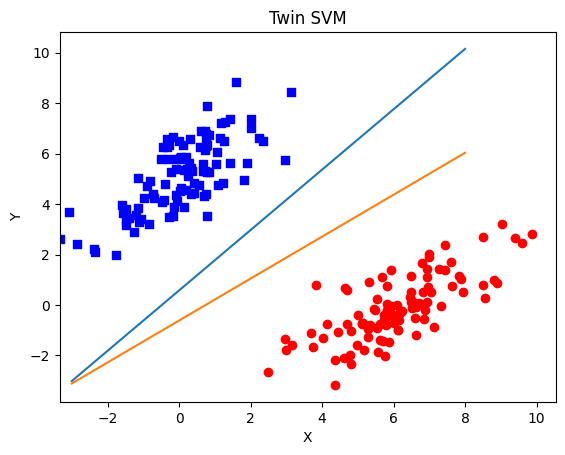

In [73]:

plt.scatter(negative_samples[:,0], negative_samples[:,1],c='b', marker="s")
plt.scatter(positive_samples[:,0], positive_samples[:,1],c='r', marker="o")
plt.xlim(min(X[:,0]))
plt.ylabel('Y')
plt.xlabel('X')
plt.title('Twin SVM hyper-plans')
x = range(int(min(X[:,0])),int(max(X[:,0])))

y1 = -(w1[0]/w1[1])*x - b1
y2 = -(w2[0]/w2[1])*x - b2

plt.plot(x,y1)
plt.plot(x,y2)

plt.show()
